In [1]:
experiment_name= "cars_resnet18_semihard_margin_p5"

In [2]:
import glob
import cv2

import matplotlib.pyplot as plt
%matplotlib inline
from pandas.core.common import flatten
import numpy as np
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import datasets
import networks

##### Cars dataset downloaded from: https://www.kaggle.com/datasets/jutrera/stanford-car-dataset-by-classes-folder/code?resource=download
This version of the dataset already has all the images in the proper training and validation folders.

In [4]:
#######################################################
#                  Create Dataset
#######################################################
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()
                               ,
                              transforms.Normalize(mean, std)
                               ])

train_dataset = datasets.CarsDataset(transform, train=True)
test_dataset = datasets.CarsDataset(transform, train=False)

In [5]:
test_dataset.labels

array([  0,   0,   0, ..., 195, 195, 195])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


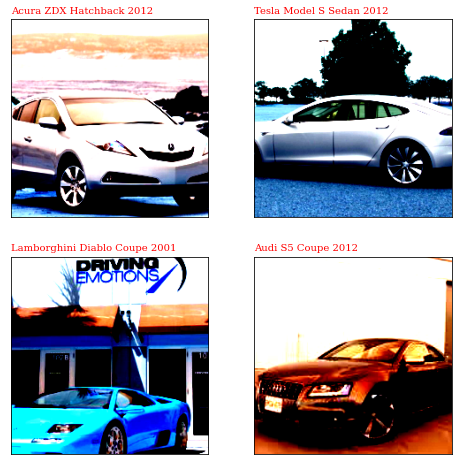

In [6]:
batch_size= 4
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Visualize some sample data
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(8, 8))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(train_loader.dataset.classes[labels[idx].item()], fontfamily='serif', loc='left', fontsize='medium', color= 'red')


In [7]:
# check if CUDA is available
cuda = torch.cuda.is_available()

if not cuda:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Online pair/triplet selection - negative mining
There are couple of problems with siamese and triplet networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

We can find some strategies on how to select triplets in [2] and [3] *Alexander Hermans, Lucas Beyer, Bastian Leibe, [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/pdf/1703.07737), 2017*

## Online triplet selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **TripletSelector** that takes embeddings and original labels and returns valid triplets within a minibatch
5. Define **OnlineTripletLoss** that will use a *TripletSelector* and compute *TripletLoss* on such pairs
6. Train the network!

In [8]:
train_dataset.labels

array([  0,   0,   0, ..., 195, 195, 195])

In [7]:
from datasets import BalancedBatchSampler

# A mini batch is created by sampling n_classes and n_samples from each class:
train_batch_sampler = BalancedBatchSampler(train_dataset.labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.labels, n_classes=10, n_samples=25)

In [8]:
train_batch_sampler

In [9]:
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler)

In [10]:
online_train_loader

In [11]:
# Load the pretrained model from pytorch
embedding_net= torchvision.models.resnet18(pretrained=True)

# print out the model structure
#print(embedding_net)

In [12]:
# Un-Freeze training for all layers parameters:
for param in embedding_net.parameters():
    param.required_grad = True    

In [13]:
embedding_net.fc= nn.Sequential(nn.Linear(512, 128),
                                nn.BatchNorm1d(128),
                                nn.ReLU(),
                                nn.Linear(128, 128), # embedding size
                                )

In [14]:
# Un-Freeze training for all layers parameters:
for param in embedding_net.parameters():
    param.required_grad = True    

In [15]:
model= networks.TripletNet(embedding_net)

In [16]:
from losses import OnlineTripletLoss
# Strategies for selecting triplets within a minibatch:
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector 

margin = 0.5
loss_fn = OnlineTripletLoss(margin, SemihardNegativeTripletSelector(margin))

In [17]:
import torch.optim as optim
optimizer = optim.Adam(model.embedding_net.parameters(), lr=1e-3)

In [18]:
device = torch.device('cuda')
model.to(device)

TripletNet(
  (embedding_net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [19]:
def train_epoch(train_loader, model, loss_fn, optimizer, log_interval, cuda):

    ###################
    # train the model #
    ###################
    model.train()

   # keep track of training loss
    train_loss = 0.0
    losses = []

    for batch_idx, (data, target) in enumerate(train_loader):
        
        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
        
        # move tensors to GPU if CUDA is available
        if cuda:
            data = tuple(d.to(device) for d in data)
            if target is not None:
                target = tuple(t.to(device) for t in target)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward pass: create embeddings of the inputs
        outputs = model.get_embedding(*data)

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)

        loss_inputs = outputs
        if target is not None:
            target = (target,)
            loss_inputs += target

        # append targets to the end of the embeddings, and calculate the batch loss
        loss_outputs = loss_fn(*loss_inputs)
        
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update training loss
        train_loss += loss.item()

        losses.append(loss.item())
        
        # Provide some feedbach within one epoch
        if batch_idx % log_interval == 0:
            print('Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(data[0]), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(losses)))
            losses = []

    # calculate average train loss (batch average is returned)
    train_loss /= (batch_idx + 1)
    
    return train_loss

In [20]:
def test_epoch(val_loader, model, loss_fn, cuda):
    
    ######################    
    # validate the model #
    ######################
    
    # keep track of validation loss
    valid_loss = 0.0
    
    with torch.no_grad():

        model.eval()
        for batch_idx, (data, target) in enumerate(val_loader):
            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            
            if cuda:
                data = tuple(d.to(device) for d in data)
                if target is not None:
                    target = tuple(t.to(device) for t in target)
            
            outputs = model.get_embedding(*data)

            if type(outputs) not in (tuple, list):
                outputs = (outputs,)
            loss_inputs = outputs
            if target is not None:
                target = (target,)
                loss_inputs += target

            loss_outputs = loss_fn(*loss_inputs)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            
            # update average validation loss 
            valid_loss += loss.item()
            
    # calculate average validation loss (batch average is returned)
    valid_loss /= (batch_idx + 1)

    return valid_loss

In [21]:
def save_model(EPOCH, model, optimizer, LOSS): # epoch and loss are numbers
    """
    Save the trained model and the optimizer to disk.
    """      
    torch.save({
                'epoch': EPOCH,
                'model_state_dict': model.embedding_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': LOSS,
                }, experiment_name+'.pt')

In [22]:
start_epoch= 0
n_epochs= 200

log_interval=10

train_losses, valid_losses = [], []

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(start_epoch, n_epochs):
    
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    train_loss = train_epoch(online_train_loader, model, loss_fn, optimizer, log_interval, cuda)
    valid_loss = test_epoch(online_test_loader, model, loss_fn, cuda)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(train_loss)
    print(valid_loss)
    # print training/validation statistics 
    print('Epoch: Epoch: {}/{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch + 1, n_epochs, train_loss, valid_loss))
          
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format( valid_loss_min,
                                                                                          valid_loss))
        save_model(epoch, model, optimizer, train_loss)
        valid_loss_min = valid_loss
    

/home/ayla/anaconda3/envs/fashion/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train: [0/8144 (0%)]	Loss: 0.247966
Train: [2500/8144 (31%)]	Loss: 0.250327
Train: [5000/8144 (62%)]	Loss: 0.249980
Train: [7500/8144 (94%)]	Loss: 0.248216
0.2493367944844067
0.2480516992509365
Epoch: Epoch: 1/200 	Training Loss: 0.249337 	Validation Loss: 0.248052
Validation loss decreased (inf --> 0.248052).  Saving model ...
Train: [0/8144 (0%)]	Loss: 0.249416
Train: [2500/8144 (31%)]	Loss: 0.249728
Train: [5000/8144 (62%)]	Loss: 0.250490
Train: [7500/8144 (94%)]	Loss: 0.250992
0.25014286721125245
0.24926769314333797
Epoch: Epoch: 2/200 	Training Loss: 0.250143 	Validation Loss: 0.249268
Train: [0/8144 (0%)]	Loss: 0.244858
Train: [2500/8144 (31%)]	Loss: 0.248699
Train: [5000/8144 (62%)]	Loss: 0.250903
Train: [7500/8144 (94%)]	Loss: 0.251300
0.25007940270006657
0.25019808439537883
Epoch: Epoch: 3/200 	Training Loss: 0.250079 	Validation Loss: 0.250198
Train: [0/8144 (0%)]	Loss: 0.249162
Train: [2500/8144 (31%)]	Loss: 0.246193
Train: [5000/8144 (62%)]	Loss: 0.246120
Train: [7500/8144 

Train: [0/8144 (0%)]	Loss: 0.225885
Train: [2500/8144 (31%)]	Loss: 0.259428
Train: [5000/8144 (62%)]	Loss: 0.260722
Train: [7500/8144 (94%)]	Loss: 0.249904
0.2550276927649975
0.2511086845770478
Epoch: Epoch: 31/200 	Training Loss: 0.255028 	Validation Loss: 0.251109
Train: [0/8144 (0%)]	Loss: 0.282041
Train: [2500/8144 (31%)]	Loss: 0.248317
Train: [5000/8144 (62%)]	Loss: 0.240582
Train: [7500/8144 (94%)]	Loss: 0.249648
0.24754621274769306
0.24764968501403928
Epoch: Epoch: 32/200 	Training Loss: 0.247546 	Validation Loss: 0.247650
Train: [0/8144 (0%)]	Loss: 0.246896
Train: [2500/8144 (31%)]	Loss: 0.237090
Train: [5000/8144 (62%)]	Loss: 0.256315
Train: [7500/8144 (94%)]	Loss: 0.253134
0.24870603997260332
0.2482653260231018
Epoch: Epoch: 33/200 	Training Loss: 0.248706 	Validation Loss: 0.248265
Train: [0/8144 (0%)]	Loss: 0.235981
Train: [2500/8144 (31%)]	Loss: 0.253228
Train: [5000/8144 (62%)]	Loss: 0.254411
Train: [7500/8144 (94%)]	Loss: 0.248756
0.25147202052176
0.249743290245533
Epoch

Train: [7500/8144 (94%)]	Loss: 0.262360
0.25286112865433097
0.2502200407907367
Epoch: Epoch: 61/200 	Training Loss: 0.252861 	Validation Loss: 0.250220
Train: [0/8144 (0%)]	Loss: 0.262421
Train: [2500/8144 (31%)]	Loss: 0.247342
Train: [5000/8144 (62%)]	Loss: 0.238097
Train: [7500/8144 (94%)]	Loss: 0.259158
0.2491397988051176
0.24784830678254366
Epoch: Epoch: 62/200 	Training Loss: 0.249140 	Validation Loss: 0.247848
Train: [0/8144 (0%)]	Loss: 0.229185
Train: [2500/8144 (31%)]	Loss: 0.245626
Train: [5000/8144 (62%)]	Loss: 0.237750
Train: [7500/8144 (94%)]	Loss: 0.247348
0.24290895089507103
0.24887389549985528
Epoch: Epoch: 63/200 	Training Loss: 0.242909 	Validation Loss: 0.248874
Train: [0/8144 (0%)]	Loss: 0.243445
Train: [2490/8144 (31%)]	Loss: 0.250008
Train: [5000/8144 (62%)]	Loss: 0.236684
Train: [7500/8144 (94%)]	Loss: 0.267384
0.2508643213659525
0.24770939722657204
Epoch: Epoch: 64/200 	Training Loss: 0.250864 	Validation Loss: 0.247709
Train: [0/8144 (0%)]	Loss: 0.276098
Train: 

Train: [0/8144 (0%)]	Loss: 0.256562
Train: [2500/8144 (31%)]	Loss: 0.246872
Train: [5000/8144 (62%)]	Loss: 0.247109
Train: [7500/8144 (94%)]	Loss: 0.228716
0.2412998117506504
0.24934353539720178
Epoch: Epoch: 92/200 	Training Loss: 0.241300 	Validation Loss: 0.249344
Train: [0/8144 (0%)]	Loss: 0.297492
Train: [2500/8144 (31%)]	Loss: 0.264747
Train: [5000/8144 (62%)]	Loss: 0.229713
Train: [7500/8144 (94%)]	Loss: 0.251463
0.25001455820165575
0.24862978514283895
Epoch: Epoch: 93/200 	Training Loss: 0.250015 	Validation Loss: 0.248630
Train: [0/8144 (0%)]	Loss: 0.272335
Train: [2500/8144 (31%)]	Loss: 0.229960
Train: [5000/8144 (62%)]	Loss: 0.241763
Train: [7500/8144 (94%)]	Loss: 0.272103
0.2489501666277647
0.24745448492467403
Epoch: Epoch: 94/200 	Training Loss: 0.248950 	Validation Loss: 0.247454
Train: [0/8144 (0%)]	Loss: 0.237981
Train: [2500/8144 (31%)]	Loss: 0.257175
Train: [5000/8144 (62%)]	Loss: 0.235003
Train: [7500/8144 (94%)]	Loss: 0.237111
0.24266265658661723
0.2492605526931584


Train: [5000/8144 (62%)]	Loss: 0.261947
Train: [7500/8144 (94%)]	Loss: 0.271008
0.2684577847830951
0.2461225907318294
Epoch: Epoch: 122/200 	Training Loss: 0.268458 	Validation Loss: 0.246123
Train: [0/8144 (0%)]	Loss: 0.257461
Train: [2500/8144 (31%)]	Loss: 0.293268
Train: [5000/8144 (62%)]	Loss: 0.273065
Train: [7500/8144 (94%)]	Loss: 0.272748
0.28002710873261094
0.24662785325199366
Epoch: Epoch: 123/200 	Training Loss: 0.280027 	Validation Loss: 0.246628
Train: [0/8144 (0%)]	Loss: 0.253271
Train: [2500/8144 (31%)]	Loss: 0.239893
Train: [5000/8144 (62%)]	Loss: 0.221572
Train: [7500/8144 (94%)]	Loss: 0.249504
0.23860261775553226
0.24712086468935013
Epoch: Epoch: 124/200 	Training Loss: 0.238603 	Validation Loss: 0.247121
Train: [0/8144 (0%)]	Loss: 0.252748
Train: [2500/8144 (31%)]	Loss: 0.242312
Train: [5000/8144 (62%)]	Loss: 0.250491
Train: [7500/8144 (94%)]	Loss: 0.258165
0.250848357565701
0.25418135477229953
Epoch: Epoch: 125/200 	Training Loss: 0.250848 	Validation Loss: 0.254181


0.24535051500424743
0.2455841819755733
Epoch: Epoch: 152/200 	Training Loss: 0.245351 	Validation Loss: 0.245584
Train: [0/8144 (0%)]	Loss: 0.256905
Train: [2500/8144 (31%)]	Loss: 0.271396
Train: [4980/8144 (62%)]	Loss: 0.276132
Train: [7500/8144 (94%)]	Loss: 0.248315
0.26791178062558174
0.2480698712170124
Epoch: Epoch: 153/200 	Training Loss: 0.267912 	Validation Loss: 0.248070
Train: [0/8144 (0%)]	Loss: 0.443527
Train: [2500/8144 (31%)]	Loss: 0.255903
Train: [5000/8144 (62%)]	Loss: 0.237662
Train: [7500/8144 (94%)]	Loss: 0.278894
0.2636076342314482
0.24691622983664274
Epoch: Epoch: 154/200 	Training Loss: 0.263608 	Validation Loss: 0.246916
Train: [0/8144 (0%)]	Loss: 0.186554
Train: [2500/8144 (31%)]	Loss: 0.247127
Train: [5000/8144 (62%)]	Loss: 0.279422
Train: [7500/8144 (94%)]	Loss: 0.212788
0.2425384451635182
0.251266585662961
Epoch: Epoch: 155/200 	Training Loss: 0.242538 	Validation Loss: 0.251267
Train: [0/8144 (0%)]	Loss: 0.237031
Train: [2500/8144 (31%)]	Loss: 0.260954
Train:

Train: [2500/8144 (31%)]	Loss: 0.265619
Train: [5000/8144 (62%)]	Loss: 0.245758
Train: [7500/8144 (94%)]	Loss: 0.258798
0.2598402122966945
0.24974587420001626
Epoch: Epoch: 183/200 	Training Loss: 0.259840 	Validation Loss: 0.249746
Train: [0/8144 (0%)]	Loss: 0.297221
Train: [2500/8144 (31%)]	Loss: 0.284821
Train: [5000/8144 (62%)]	Loss: 0.296224
Train: [7470/8144 (94%)]	Loss: 0.261706
0.27957471227273345
0.2453134385868907
Epoch: Epoch: 184/200 	Training Loss: 0.279575 	Validation Loss: 0.245313
Train: [0/8144 (0%)]	Loss: 0.265320
Train: [2500/8144 (31%)]	Loss: 0.238113
Train: [5000/8144 (62%)]	Loss: 0.273824
Train: [7500/8144 (94%)]	Loss: 0.273214
0.26374069415032864
0.2534078424796462
Epoch: Epoch: 185/200 	Training Loss: 0.263741 	Validation Loss: 0.253408
Train: [0/8144 (0%)]	Loss: 0.283791
Train: [2500/8144 (31%)]	Loss: 0.273198
Train: [5000/8144 (62%)]	Loss: 0.202029
Train: [7500/8144 (94%)]	Loss: 0.264526
0.25122195109725
0.24644846050068736
Epoch: Epoch: 186/200 	Training Loss

In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

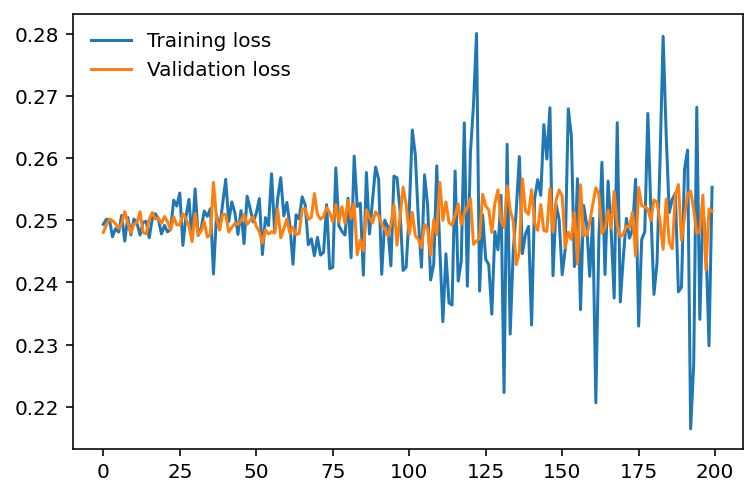

In [24]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

In [25]:
# write training results:
f = open(experiment_name+ "_result"+".csv", "w")
f.write('\t'.join(('tr_er', 'val_er')))
f.write('\n')
for (tr_er, val_er) in zip(train_losses, valid_losses,):
    items= (str(tr_er),',', str(val_er))
    f.write('\t'.join(items))
    f.write('\n')
f.close()

In [ ]:
# Load model and optimizer from disk:
embedding_net= torchvision.models.resnet18(pretrained=True)

# Freeze training for all layers parameters:
for param in embedding_net.parameters():
    param.required_grad = False    
    
embedding_net.fc= nn.Sequential(nn.Linear(512, 128),
                                nn.BatchNorm1d(128),
                                nn.ReLU(),
                                nn.Linear(128, 128), # embedding size
                                )

model= networks.TripletNet(embedding_net)

import torch.optim as optim
optimizer = optim.Adam(model.embedding_net.fc.parameters(), lr=1e-3)

PATH= experiment_name+'.pt'
check_point= torch.load(PATH)

model.embedding_net.load_state_dict(check_point['model_state_dict'])
optimizer.load_state_dict(check_point['optimizer_state_dict'])
epoch = check_point['epoch']
loss = check_point['loss']


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()